## Lattice Perturbation Experiment

This simulation studies how the Lasso regression model evolves as we continuously deform a regular lattice into a random geometric graph. Starting from a perfect square (or triangular) lattice at `perturb_scale = 0`, nodes are progressively displaced by increasing amounts, with the perturbation scale serving as a proxy for the degree of geometric disorder.

The central question is how the functional form of effective resistance (in terms of distance, angle, and degree) changes across this deformation.

### Scaling the radius multiplier Across Lattice Orders

We noticed that when we perturb the nodes of the lattice while keeping the same radius of connection the mean degree of our graphs dropped significantly, thus we have added a correction term. The term `perturb_radius_multiplier_` is calculated as follows. Let $k_0$ denote the degree of a node and $k$ denote the epxected mean degree. We know that $k = \mathbb{E}[k_0] = n \pi r^2$ with $n$ the number of nodes in the graph and $r$ the radius of connection. 

For the order 1 square lattice i.e. only nearst vertices are connected, we have $r = \frac{1}{\sqrt{n}}$. Thus if we want the perturbed graph's expected mean degree to match that of the order 1 square lattice we need to scale our radius by some positive scalar $c$ so that: $$4 = n \pi (cr)^2 \implies \frac{4}{\pi} = c^2 \implies c = \frac{2}{\sqrt{\pi}} \approx 1.128$$

When the lattice is of higher order we repeat the same process, but with $r = \frac{d}{\sqrt{n}}$ where $d$ is ratio of the max distance between neighboring nodes and the minimum distance between neighboring nodes.

We note this is an approxiamted term due to the fact that these perturbed lattices follow a different distribution than the standard RGGs where we uniformly randomly place vertices on the torus. However, this approximation works well numerically.

We provide a function radius_multiplier_calc_square_lattice() to calculate the radius multiplier using the following smaller inputs:
- Order 1: $1, 4$ 
- Order 2: $\sqrt{2}, 8$
- Order 3: $2, 12$
- Order 4: $\sqrt{5}, 20$
- Order 5: $\sqrt{8}, 24$

Starting Geometric Experiment: 4 steps.
Step 1: Perturb=False (Perfect Lattice)
Steps 2+: Perturb=True


100%|██████████| 4/4 [00:51<00:00, 12.83s/it]


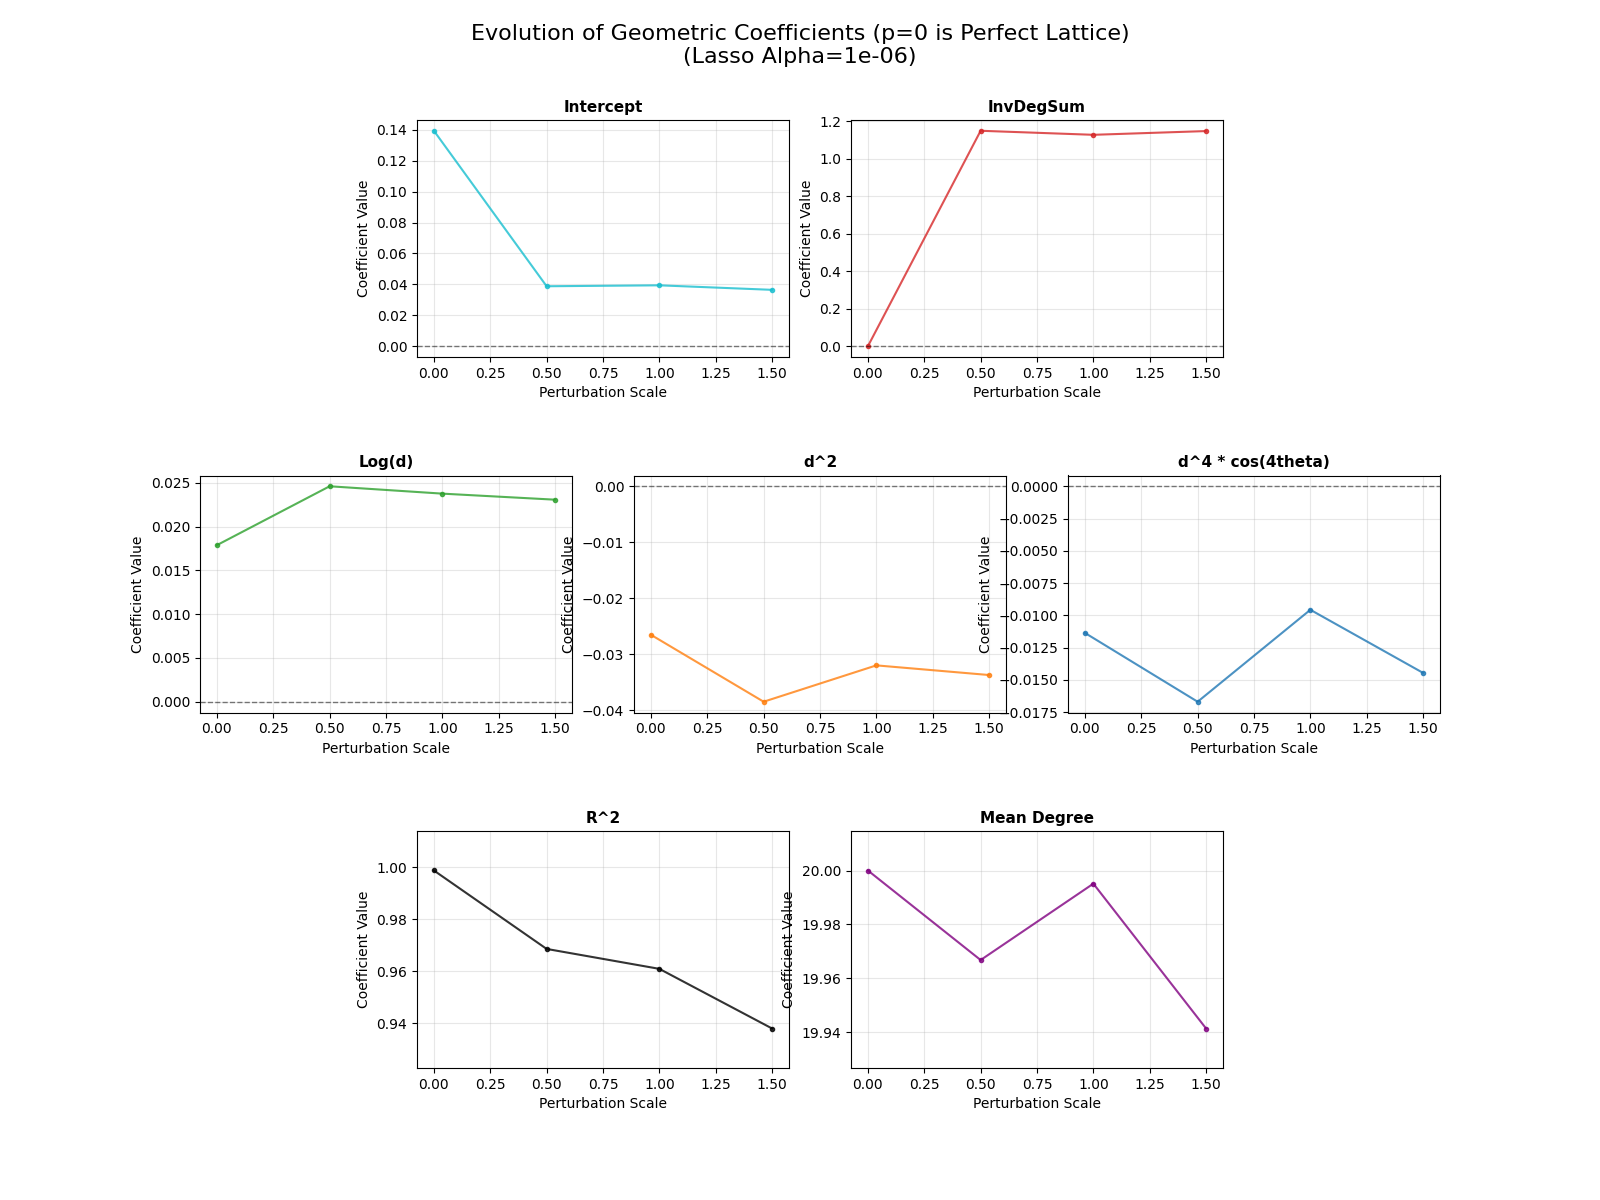


--- Results DataFrame ---
                         R^2  Mean Degree  Perturbed  Intercept    Log(d)       d^2  d^4 * cos(4theta)  InvDegSum
Perturbation Scale                                                                                               
0.0                 0.998699    20.000000      False   0.139385  0.017873 -0.026507          -0.011360   0.000000
0.5                 0.968538    19.966797       True   0.038798  0.024594 -0.038457          -0.016691   1.149462
1.0                 0.960872    19.995117       True   0.039402  0.023753 -0.031968          -0.009569   1.127921
1.5                 0.937935    19.941406       True   0.036479  0.023063 -0.033691          -0.014459   1.147867

Results saved to: Latice_Perturbation_Experiment_Results.csv


In [ ]:
%matplotlib widget
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import pandas as pd

# --- IMPORTS FOR ML ---
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- USER PATH ---
from RGG_Library import RGGBuilder

# --------------------------------------------------------------------------------
# PERTURBATION MULTIPLIER HELPER FUNCTION
# --------------------------------------------------------------------------------
def radius_multiplier_calc_square_lattice(dist, exp_k):
    return np.sqrt(exp_k / (dist**2 * np.pi))

# --------------------------------------------------------------------------------
# CONFIGURATION
# --------------------------------------------------------------------------------

# Experiment Range:
PERTURB_VALUES = np.concatenate(([0.0], np.arange(0.5, 2, 0.5)))

SPACE                       = ["square_torus", "triangular_torus"][0]
USE_ANGLES                  = [True, False][0]
LASSO_ALPHA                 = 1e-6
CONNECTIVITY_REGIME         = ["sc","c"][0]

ORDER                       = 4
MAX_DIST_FOR_ORDER          = np.sqrt(5)
DEGREE_FOR_ORDER            = 20

PERTURB_RADIUS_MULTIPLIER   = radius_multiplier_calc_square_lattice(dist=MAX_DIST_FOR_ORDER, exp_k=DEGREE_FOR_ORDER)

N_NODES                     = 1024
K_NEIGHBORS                 = 20
N_SAMPLES                   = 1000
N_BINS                      = 20

N_TRAIN_GRAPHS              = 80
N_TEST_GRAPHS               = 20
BASE_SEED                   = 0


# --------------------------------------------------------------------------------
# RGG BUILDER
# --------------------------------------------------------------------------------

def build_RGG(perturb_val, iteration_seed):
    """
    Generates a graph, returns samples.

    NOTE ON FEATURE SHAPES (FIX 3):
    --------------------------------
    The feature matrix X has different numbers of columns depending on whether
    perturbation is active:

      - perturb=False (perfect lattice, p=0.0):  3 features
        ["Log(d)", "d^2", "d^4 * cos(4theta)"]

      - perturb=True (p > 0.0):                  4 features
        ["Log(d)", "d^2", "d^4 * cos(4theta)", "InvDegSum"]

    This is intentional: InvDegSum is only meaningful when node degrees vary
    (i.e. under perturbation). On a perfect lattice all nodes have the same
    degree so InvDegSum adds no signal and is excluded to keep the lattice
    model parsimonious.

    Consequence for result collection: in the simulation loop, results are
    stored via `coefs.get(key, 0.0)`, so "InvDegSum" is recorded as 0.0 for
    the unperturbed case. This is correct by design — it simply means that
    feature is absent (zero coefficient) for the perfect-lattice model.

    Since p is always the same for both train and test calls within a single
    compute_r2 invocation, the column count will always match between train
    and test sets, so no shape mismatch crash will occur.
    """
    # --- 1. Graph Generation ---
    if perturb_val == 0.0:
        perturb = False
        perturb_scale = 0.0
    else:
        perturb = True
        perturb_scale = perturb_val
    
    builder = RGGBuilder(
        n                           = N_NODES,
        k                           = K_NEIGHBORS,
        connectivity_regime         = CONNECTIVITY_REGIME,
        space                       = SPACE,
        order                       = ORDER,
        perturb                     = perturb,
        perturb_scale               = perturb_scale,
        perturb_radius_multiplier   = PERTURB_RADIUS_MULTIPLIER,
        seed                        = iteration_seed
    )
    
    G = builder.build()

    # Ensure Giant Component
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        Gsub = G.subgraph(max(components, key=len)).copy()
    else:
        Gsub = G
    
    Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")

    # Calculate Mean Degree: (2 * edges) / nodes
    mean_degree = 2 * Gsub.number_of_edges() / Gsub.number_of_nodes()

    # --- 2. Sample Data ---
    random.seed(iteration_seed)
    np.random.seed(iteration_seed)

    # Correcting the minimum distance for sampling if perturbation occurs
    if perturb == False:
        min_distances = builder.radius
    else:
        min_distances = builder.radius * PERTURB_RADIUS_MULTIPLIER
    
    if USE_ANGLES:
        res, degs, dists, pairs, angles = RGGBuilder.sample_commute_times_even_distance_w_angles(
            Gsub, nsamples=N_SAMPLES, n_bins=N_BINS, seed=iteration_seed, 
            min_dist=min_distances, max_dist=2
        )
    else:
        res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
            Gsub, nsamples=N_SAMPLES, n_bins=N_BINS, seed=iteration_seed, 
            min_dist=min_distances, max_dist=2
        )
        angles = np.zeros_like(dists)

    # --- 3. Feature Engineering ---
    safe_dists = dists.copy()
    safe_dists[safe_dists == 0] = 1e-9 

    # See docstring above for explanation of why feature sets differ.
    if perturb == False:
        feature_dict = {
            "Log(d)": np.log(safe_dists),
            "d^2": dists**2,
            "d^4 * cos(4theta)": dists**4 * np.cos(4*angles),
        }
    else:
        feature_dict = {
            "Log(d)": np.log(safe_dists),
            "d^2": dists**2,
            "d^4 * cos(4theta)": dists**4 * np.cos(4*angles),
            "InvDegSum": degs,
        }

    feature_names = list(feature_dict.keys())
    X = np.column_stack(list(feature_dict.values()))
    y = res

    return X, y, feature_names, mean_degree

# --------------------------------------------------------------------------------
# COMPUTING R^2
# --------------------------------------------------------------------------------

def compute_r2(n, k, p, base_seed=BASE_SEED):
    """
    Train LASSO on N_TRAIN_GRAPHS pooled graphs, test on N_TEST_GRAPHS pooled graphs.
    Returns a dict of coefficients, metadata, and out-of-sample R². Returns NaN on failure.
    """
    try:
        # --- TRAINING: pool data from N_TRAIN_GRAPHS graphs ---
        X_train_parts, y_train_parts = [], []
        mean_degrees = []  # FIX 4: collect mean_degree from all training graphs

        for i in range(N_TRAIN_GRAPHS):
            X, y, feature_names, mean_degree = build_RGG(p, base_seed + i)
            if X is not None:
                X_train_parts.append(X)
                y_train_parts.append(y)
                mean_degrees.append(mean_degree)  # FIX 4: accumulate

        if len(X_train_parts) == 0:
            return np.nan

        X_train = np.vstack(X_train_parts)
        y_train = np.concatenate(y_train_parts)

        # FIX 4: average mean_degree across all training graphs rather than
        # using only the last graph's value (graphs may differ slightly in size
        # after giant-component extraction)
        mean_degree_avg = np.mean(mean_degrees)

        # --- FIT LASSO ---
        # FIX 2: use LASSO_ALPHA config variable instead of hardcoded 1e-6
        model = make_pipeline(
            StandardScaler(),
            Lasso(alpha=LASSO_ALPHA, random_state=0, max_iter=50000)
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)

        lasso  = model.named_steps['lasso']
        scaler = model.named_steps['standardscaler']
        real_coefs     = lasso.coef_ / scaler.scale_
        real_intercept = lasso.intercept_ - np.sum(real_coefs * scaler.mean_)

        # --- TESTING: pool data from N_TEST_GRAPHS graphs ---
        # Use seeds that don't overlap with training seeds
        X_test_parts, y_test_parts = [], []
        for i in range(N_TEST_GRAPHS):
            X, y, _, _ = build_RGG(p, base_seed + N_TRAIN_GRAPHS + i)
            if X is not None:
                X_test_parts.append(X)
                y_test_parts.append(y)

        # FIX 1: guard is now OUTSIDE the loop at the correct indentation level
        # (previously it was inside 'if X is not None', so it could never trigger)
        if len(X_test_parts) == 0:
            return np.nan

        X_test = np.vstack(X_test_parts)
        y_test = np.concatenate(y_test_parts)

        # --- OUT-OF-SAMPLE R² ---
        y_pred  = X_test @ real_coefs + real_intercept
        ss_res  = np.sum((y_test - y_pred) ** 2)
        ss_tot  = np.sum((y_test - np.mean(y_test)) ** 2)
        r2      = 1 - ss_res / ss_tot

        # Build result dictionary
        results = dict(zip(feature_names, real_coefs))
        results["Intercept"]   = real_intercept
        results["Mean Degree"] = mean_degree_avg  # FIX 4: averaged value
        results["R^2"]         = r2
        
        return results

    except Exception as e:
        print(f"  [WARN] n={n}, k={k} failed: {e}")
        return np.nan

# --------------------------------------------------------------------------------
# SIMULATION
# --------------------------------------------------------------------------------
history = {key: [] for key in [
        "R^2",
        "Intercept",
        "Mean Degree",
        "Log(d)", 
        "d^2", 
        "d^4 * cos(4theta)", 
        "InvDegSum",
    ]}

print(f"Starting Geometric Experiment: {len(PERTURB_VALUES)} steps.")
print("Step 1: Perturb=False (Perfect Lattice)")
print("Steps 2+: Perturb=True")

perturb_vals_plotted = []

for i, p in enumerate(tqdm(PERTURB_VALUES)):
    try:
        coefs = compute_r2(N_NODES, K_NEIGHBORS, p, base_seed=BASE_SEED)
            
        for key in history.keys():
            history[key].append(coefs.get(key, 0.0))
            
        perturb_vals_plotted.append(p)
                
    except Exception as e:
        print(f"Skipping p={p:.2f} due to error: {e}")

# --------------------------------------------------------------------------------
# VISUALIZATION
# --------------------------------------------------------------------------------

# Layout: 2 (top) - 3 (middle) - 2 (bottom)
# Top row:    Intercept, InvDegSum         (centred)
# Middle row: Log(d), d^2, d^4*cos(4theta)
# Bottom row: R^2, Mean Degree             (centred)

TOP_ROW    = ["Intercept", "InvDegSum"]
MIDDLE_ROW = ["Log(d)", "d^2", "d^4 * cos(4theta)"]
BOTTOM_ROW = ["R^2", "Mean Degree"]

def get_color(feature_name):
    if feature_name == "R^2":          return 'black'
    elif "Log" in feature_name:        return 'tab:green'
    elif "1/" in feature_name:         return 'tab:red'
    elif "^2" in feature_name:         return 'tab:orange'
    elif "Degree" in feature_name:     return 'purple'
    elif "Intercept" in feature_name:  return 'tab:cyan'
    elif "InvDeg" in feature_name:     return 'tab:red'
    else:                              return 'tab:blue'

def plot_ax(ax, feature_name):
    y_vals = history[feature_name]
    color  = get_color(feature_name)

    ax.plot(perturb_vals_plotted, y_vals,
            marker='o', markersize=3, linewidth=1.5, color=color, alpha=0.8)
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

    if feature_name in ("R^2", "Mean Degree"):
        y_min, y_max = min(y_vals), max(y_vals)
        padding = (y_max - y_min) * 0.25 if y_max != y_min else 0.5
        ax.set_ylim(y_min - padding, y_max + padding)

    ax.set_title(feature_name, fontsize=11, fontweight='bold')
    ax.set_xlabel("Perturbation Scale")
    ax.set_ylabel("Coefficient Value")
    ax.grid(True, alpha=0.3)

# --- Build figure with GridSpec ---
# Use a 6-column grid so that:
#   - 2-panel rows occupy cols [1:3] and [3:5]  → centred over 6 cols
#   - 3-panel rows occupy cols [0:2], [2:4], [4:6]
fig = plt.figure(figsize=(16, 12))
gs  = fig.add_gridspec(3, 6)

# Top row: 2 panels centred (start at col 1, each spans 2 cols)
top_axes = [
    fig.add_subplot(gs[0, 1:3]),
    fig.add_subplot(gs[0, 3:5]),
]

# Middle row: 3 panels spanning all 6 cols (each spans 2 cols)
mid_axes = [
    fig.add_subplot(gs[1, 0:2]),
    fig.add_subplot(gs[1, 2:4]),
    fig.add_subplot(gs[1, 4:6]),
]

# Bottom row: 2 panels centred (same as top)
bot_axes = [
    fig.add_subplot(gs[2, 1:3]),
    fig.add_subplot(gs[2, 3:5]),
]

for ax, name in zip(top_axes, TOP_ROW):
    plot_ax(ax, name)

for ax, name in zip(mid_axes, MIDDLE_ROW):
    plot_ax(ax, name)

for ax, name in zip(bot_axes, BOTTOM_ROW):
    plot_ax(ax, name)

fig.suptitle(
    f"Evolution of Geometric Coefficients (p=0 is Perfect Lattice)\n(Lasso Alpha={LASSO_ALPHA})",
    fontsize=16
)

fig.subplots_adjust(top=0.90, hspace=0.5, wspace=0.4)
plt.show()

# --------------------------------------------------------------------------------
# SAVE RESULTS TO DATAFRAME
# --------------------------------------------------------------------------------

# Build DataFrame from history dict.
# Each row = one perturbation value; each column = one tracked quantity.
# NOTE: InvDegSum will be 0.0 for the unperturbed (p=0) row — this is expected,
# as that feature is excluded from the lattice model (see build_RGG docstring).
df_results = pd.DataFrame(history, index=perturb_vals_plotted)
df_results.index.name = "Perturbation Scale"

# Add a convenience column flagging whether a row used a perturbed graph
df_results["Perturbed"] = df_results.index > 0.0

# Reorder columns: metadata first, then coefficients
META_COLS    = ["R^2", "Mean Degree", "Perturbed"]
COEF_COLS    = ["Intercept", "Log(d)", "d^2", "d^4 * cos(4theta)", "InvDegSum"]
df_results   = df_results[META_COLS + COEF_COLS]

print("\n--- Results DataFrame ---")
print(df_results.to_string())

# --- Save to CSV ---
CSV_PATH = "Latice_Perturbation_Experiment_Results.csv"
df_results.to_csv(CSV_PATH)
print(f"\nResults saved to: {CSV_PATH}")

## Older Code

In [ ]:
%matplotlib widget
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm  # For progress bar

# --- IMPORTS FOR ML ---
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- USER PATH ---
from RGG_Library import RGGBuilder

# --------------------------------------------------------------------------------
# PERTURBATION MULTIPLIER HELPER FUNCTION
# --------------------------------------------------------------------------------
def radius_multiplier_calc_square_lattice(dist, exp_k):
    return np.sqrt(exp_k / (dist**2 * np.pi))

# --------------------------------------------------------------------------------
# CONFIGURATION
# --------------------------------------------------------------------------------

# Experiment Range:
PERTURB_VALUES = np.concatenate(([0.0], np.arange(0.5, 10.5, 0.5)))

SPACE                       = ["square_torus", "triangular_torus"][0]
USE_ANGLES                  = [True, False][0]
LASSO_ALPHA                 = 1e-6
CONNECTIVITY_REGIME         = ["sc","c"][0]

ORDER                       = 4
MAX_DIST_FOR_ORDER          = np.sqrt(5)
DEGREE_FOR_ORDER            = 20

PERTURB_RADIUS_MULTIPLIER   = radius_multiplier_calc_square_lattice(dist=MAX_DIST_FOR_ORDER, exp_k=DEGREE_FOR_ORDER)

N_NODES                     = 256
K_NEIGHBORS                 = 20
N_SAMPLES                   = 1000

# --------------------------------------------------------------------------------
# SIMULATION FUNCTION
# --------------------------------------------------------------------------------
def get_coefficients_for_perturbation(perturb_val, iteration_seed):
    """
    Generates a graph, runs Lasso, and returns Real Coefs + Intercept + Mean Degree.
    """
    
    # --- 1. Graph Generation ---
    if perturb_val == 0.0:
        perturb = False
        perturb_scale = 0.0
    else:
        perturb = True
        perturb_scale = perturb_val
    
    builder = RGGBuilder(
        n=N_NODES,
        k=K_NEIGHBORS,
        connectivity_regime=CONNECTIVITY_REGIME,
        space=SPACE,
        order=ORDER,
        perturb=perturb,
        perturb_scale=perturb_scale,
        perturb_radius_multiplier=PERTURB_RADIUS_MULTIPLIER,
        seed=iteration_seed
    )
    
    G = builder.build()

    # Ensure Giant Component
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        Gsub = G.subgraph(max(components, key=len)).copy()
    else:
        Gsub = G
    
    Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")

    # --- NEW: Calculate Mean Degree ---
    # (2 * edges) / nodes
    mean_degree = 2 * Gsub.number_of_edges() / Gsub.number_of_nodes()

    # --- 2. Sample Data ---
    random.seed(iteration_seed)
    np.random.seed(iteration_seed)
    
    if USE_ANGLES:
        res, degs, dists, pairs, angles = RGGBuilder.sample_commute_times_even_distance_w_angles(
            Gsub, nsamples=N_SAMPLES, n_bins=20, seed=iteration_seed, 
            min_dist=builder.radius, max_dist=2
        )
    else:
        res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
            Gsub, nsamples=N_SAMPLES, n_bins=20, seed=iteration_seed, 
            min_dist=builder.radius, max_dist=2
        )
        angles = np.zeros_like(dists)

    # --- 3. Feature Engineering ---
    safe_dists = dists.copy()
    safe_dists[safe_dists == 0] = 1e-9 

    # Define features based on perturbation state
    if perturb == False:
        feature_dict = {
            "Log(d)": np.log(safe_dists),
            "d^2": dists**2,
            "d^4 * cos(4theta)": dists**4 * np.cos(4*angles),
        }
    else:
        feature_dict = {
            "Log(d)": np.log(safe_dists),
            "d^2": dists**2,
            "d^4 * cos(4theta)": dists**4 * np.cos(4*angles),
            "InvDegSum": degs,
        }

    feature_names = list(feature_dict.keys())
    X = np.column_stack(list(feature_dict.values()))
    y = res

    # --- 4. Lasso Regression ---
    model = make_pipeline(
        StandardScaler(), 
        Lasso(alpha=LASSO_ALPHA, max_iter=50000, tol=1e-4)
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X, y)
        # --- NEW: Calculate R^2 Score ---
        r2_score = model.score(X, y)

    # --- 5. Extract Unscaled Coefficients & Intercept ---
    lasso = model.named_steps['lasso']
    scaler = model.named_steps['standardscaler']
    
    sigmas = scaler.scale_
    sigmas[sigmas == 0] = 1.0 
    
    real_coefs = lasso.coef_ / sigmas
    real_intercept = lasso.intercept_ - np.dot(real_coefs, scaler.mean_)

    # Create result dictionary
    results = dict(zip(feature_names, real_coefs))
    
    # Add metadata
    results["Intercept"] = real_intercept
    results["Mean Degree"] = mean_degree
    results["R^2"] = r2_score  # <--- Added
    
    return results

# --------------------------------------------------------------------------------
# MAIN EXECUTION LOOP
# --------------------------------------------------------------------------------

history = {key: [] for key in [
    "R^2",
    "Intercept",
    "Mean Degree",
    "Log(d)", 
    "d^2", 
    "d^4 * cos(4theta)", 
    "InvDegSum",
]}

print(f"Starting Geometric Experiment: {len(PERTURB_VALUES )} steps.")
print("Step 1: Perturb=False (Perfect Lattice)")
print("Steps 2+: Perturb=True (Scale epsilon -> 1.5)")

perturb_vals_plotted = []

for i, p in enumerate(tqdm(PERTURB_VALUES)):
    try:
        coefs = get_coefficients_for_perturbation(p, iteration_seed=0)
        
        for key in history.keys():
            history[key].append(coefs.get(key, 0.0))
        
        perturb_vals_plotted.append(p)
            
    except Exception as e:
        print(f"Skipping p={p:.2f} due to error: {e}")

# --------------------------------------------------------------------------------
# VISUALIZATION
# --------------------------------------------------------------------------------

features_to_plot = list(history.keys())
n_feats = len(features_to_plot)
cols = 3
rows = (n_feats // cols) + (1 if n_feats % cols > 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(14, 3.5 * rows), constrained_layout=True)
axes = axes.flatten()

for i, feature_name in enumerate(features_to_plot):
    ax = axes[i]
    y_vals = history[feature_name]
    
    if feature_name == "R^2":
        color = 'black'
        ax.set_ylim(0, 1.05)
    elif "Log" in feature_name: color = 'tab:green'
    elif "1/" in feature_name: color = 'tab:red'
    elif "^2" in feature_name: color = 'tab:orange'
    elif "Degree" in feature_name: color = 'purple'
    else: color = 'tab:blue'
    
    ax.plot(perturb_vals_plotted, y_vals, marker='o', markersize=3, linewidth=1.5, color=color, alpha=0.8)
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_title(feature_name, fontsize=11, fontweight='bold')
    ax.set_xlabel("Perturbation Scale")
    ax.set_ylabel("Coefficient Value")
    ax.grid(True, alpha=0.3)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle(f"Evolution of Geometric Coefficients (p=0 is Perfect Lattice)\n(Lasso Alpha={LASSO_ALPHA})", fontsize=16)
plt.show()